본 코드에서는 아래의 예제 텍스트에 대해 명사 단어들로 구성된 네트워크를 생성하고, 그에 대한 기본적인 네트워크 분석을 수행합니다. <br>
노드: 명사 단어들 <br>
tie: 두 단어가 동일 문장에서 함께 사용된 경우 tie가 존재한다고 정의

In [1]:
text1 = 'The carrot is one of vegetables. Research shows vegetables are good for health. Thus, carrots are also good for health. Your health can be improved with carrots.'

In [3]:
# 텍스트를 문장 단위로 구분하기 위한 함수, 정규표현식을 사용
import re
def get_sentences(text):
    sentences = re.split(r'[\.\?\!]\s+', text)
    return sentences

In [4]:
sentences = get_sentences(text1.lower()) # 문장 단위로 구분
print(sentences)

['the carrot is one of vegetables', 'research shows vegetables are good for health', 'thus, carrots are also good for health', 'your health can be improved with carrots.']


### 각 문장에 대한 전처리 => 명사 단어를 추출

In [5]:
import nltk
filtered_sentences = [re.sub(r'[^\s\d\w]','',sent) for sent in sentences] # 각 문장에 존재하는 기호 제거
tagged_words = [nltk.pos_tag(nltk.word_tokenize(sent)) for sent in filtered_sentences] # 단어 단위로 구분 후, PoS tagging
print(tagged_words)

[[('the', 'DT'), ('carrot', 'NN'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('vegetables', 'NNS')], [('research', 'NN'), ('shows', 'VBZ'), ('vegetables', 'NNS'), ('are', 'VBP'), ('good', 'JJ'), ('for', 'IN'), ('health', 'NN')], [('thus', 'RB'), ('carrots', 'NNS'), ('are', 'VBP'), ('also', 'RB'), ('good', 'JJ'), ('for', 'IN'), ('health', 'NN')], [('your', 'PRP$'), ('health', 'NN'), ('can', 'MD'), ('be', 'VB'), ('improved', 'VBN'), ('with', 'IN'), ('carrots', 'NNS')]]


tagged_words에서 명사 단어들만 추출 후, 원형찾기(lemmatization) 작업 수행

In [6]:
final_sentences = []
wlem = nltk.WordNetLemmatizer()
for sent in tagged_words:
    noun_sent = []
    for word, pos in sent:
        if 'NN' in pos:
            noun_sent.append(wlem.lemmatize(word))
    final_sentences.append(noun_sent)
print(final_sentences)

[['carrot', 'vegetable'], ['research', 'vegetable', 'health'], ['carrot', 'health'], ['health', 'carrot']]


### 전체 단어 목록 추출

In [7]:
total_nouns = []
for words in final_sentences:
    total_nouns.extend(words)
unique_nouns = set(total_nouns)
print(unique_nouns)

{'health', 'carrot', 'vegetable', 'research'}


## 위의 단어 정보와 문장 정보를 사용하여 텍스트에 대한 네트워크 생성

In [7]:
import networkx as nx
g = nx.Graph() # Empty network 생성
g.add_nodes_from(unique_nouns) # 노드 추가

#### 문장 정보를 이용하여 두 단어 사이의 타이 정보 추출 후, 네트워크에 추가

In [8]:
import itertools
for pair in list(itertools.combinations(list(unique_nouns), 2)):
    if pair[0] == pair[1]:
        continue
    for sent in final_sentences:
        if pair[0] in sent and pair[1] in sent:
            if pair in list(g.edges()) or (pair[1],pair[0]) in list(g.edges()): 
                g[pair[0]][pair[1]]['weight'] += 1
            else:
                g.add_edge(pair[0], pair[1], weight=1 )

## 네트워크 분석

노드 목록 보기

In [9]:
print(g.nodes())

['carrot', 'research', 'vegetable', 'health']


타이 목록 보기

In [10]:
print(g.edges())

[('carrot', 'vegetable'), ('carrot', 'health'), ('research', 'vegetable'), ('research', 'health'), ('vegetable', 'health')]


특정 단어, 여기서는 carrot과 연결된 다른 단어 정보 보기

In [14]:
print(g['carrot'])

{'vegetable': {'weight': 1}, 'health': {'weight': 2}}


matplotlib을 이용해서 시각화 하기

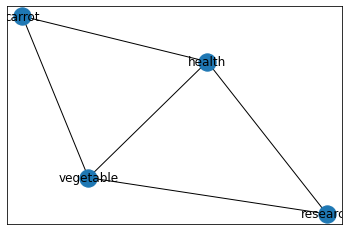

In [13]:
import matplotlib.pyplot as plt
nx.draw_networkx(g)
plt.show()

### 각 단어들의 중심도 계산하기

#### Degree centrality

In [15]:
nx.degree_centrality(g)

{'carrot': 0.6666666666666666,
 'research': 0.6666666666666666,
 'vegetable': 1.0,
 'health': 1.0}

#### Betweenness centrality

In [16]:
nx.betweenness_centrality(g)

{'carrot': 0.0,
 'research': 0.0,
 'vegetable': 0.16666666666666666,
 'health': 0.16666666666666666}

#### Closeness centrality

In [17]:
nx.closeness_centrality(g)

{'carrot': 0.75, 'research': 0.75, 'vegetable': 1.0, 'health': 1.0}

#### Eigenvector centrality

In [78]:
nx.eigenvector_centrality(g)

{'carrot': 0.43516217270028296,
 'health': 0.5573453897277424,
 'research': 0.43516217270028296,
 'vegetable': 0.5573453897277424}

Gephi 시각화를 위해 graphml 파일로 저장하기

In [ ]:
nx.write_graphml(g, 'example.graphml')

# 인접 행렬을 사용해서 네트워크 생성하기
이부분은 sklearn 부분을 공부한 후에 보세요.

In [8]:
sentences_filtered = [' '.join(sentence) for sentence in final_sentences]

In [9]:
sentences_filtered[0]

'carrot vegetable'

In [10]:
from sklearn.feature_extraction.text import CountVectorizer # frequency based DTM
def tf_extractor(corpus): 
    # returns a frequency-based DTM
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
    # min_df: minimum document frequency threshold
         # if min_df = 1 -> 최소 적어도 하나의 문서에서 사용된 단어들은 모두 포함
    # ngram_range=(1,1) -> unigram 만 포함
    # ngram_range=(1,3) -> unigram, bi-gram, tri-gram 까지 고려
    features = vectorizer.fit_transform(corpus) # transform texts to a frequency matrix
    return vectorizer, features  

In [11]:
vectorizer_tf, STM_tf = tf_extractor(sentences_filtered)

In [12]:
import numpy as np

In [13]:
# 텍스트 데이터에 대한 DTM (Document Term Matrix)를 구합니다.
STM = np.array(STM_tf.todense())

In [14]:
import pandas as pd
def display_features(features, feature_names):
    df = pd.DataFrame(data=features, columns=feature_names)
    #df.to_excel('test1.xlsx')
    print(df)

In [16]:
feature_names = vectorizer_tf.get_feature_names_out()
feature_names

array(['carrot', 'health', 'research', 'vegetable'], dtype=object)

In [17]:
display_features(STM, feature_names)

   carrot  health  research  vegetable
0       1       0         0          1
1       0       1         1          1
2       1       1         0          0
3       1       1         0          0


In [20]:
# 문장을 기준으로 단어들의 공동 출현 행렬 생성 => 이것이 네트워크를 생성하는데
# 사용되는 인접행렬이 됩니다. 
words_coccurrence = np.dot(STM.T, STM)

In [19]:
words_coccurrence

array([[3, 2, 0, 1],
       [2, 3, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 2]], dtype=int64)

In [22]:
# 자기 자신에 대한 연결 정보는 사용하지 않기 때문에 대각 셀의 값은 0으로 변경합니다.
np.fill_diagonal(words_coccurrence,0)
words_coccurrence

array([[0, 2, 0, 1],
       [2, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 0]], dtype=int64)

In [23]:
import networkx as nx
import matplotlib.pyplot as plt 

In [24]:
# 위의 인접행렬을 이용해서 네트워크를 생성합니다.
g = nx.convert_matrix.from_numpy_array(words_coccurrence)

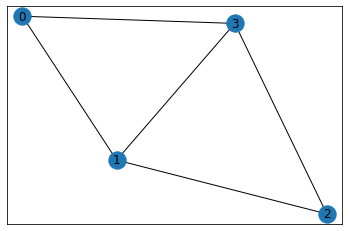

In [26]:
# 시각화 하기
nx.draw_networkx(g)
plt.show()

위의 그림을 보면 단어들의 레이블 정보가 반영이 안된 것을 알 수 있습니다. 단어들의 레이블 정보를 추가해 보겠습니다. 

In [27]:
mapping = {}
for k, word in enumerate(feature_names):
    mapping[k]=word

In [28]:
mapping

{0: 'carrot', 1: 'health', 2: 'research', 3: 'vegetable'}

In [30]:
# 위의 mapping 정보를 사용해서 단어들의 레이블 정보를 추가합니다. 
g1 = nx.relabel_nodes(g, mapping)

In [31]:
g1.nodes()

NodeView(('carrot', 'health', 'research', 'vegetable'))

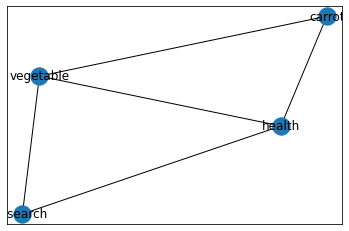

In [32]:
nx.draw_networkx(g1)
plt.show()

In [34]:
# 'carrot'에 대한 정보 보기
g1['carrot']

AtlasView({'health': {'weight': 2}, 'vegetable': {'weight': 1}})